# Lecture 7 - Decision Trees and Random Forests

```{contents}
:local:
:depth: 1
```

## Learning goals

- Explain the intuition of **decision trees** for regression and classification.
- Read **Gini** and **entropy** for splits and **MSE** for regression splits.
- Grow a tree step by step and inspect internal structures: nodes, depth, leaf counts.
- Control tree growth with `max_depth`, `min_samples_leaf`, `min_samples_split`.
- Visualize a fitted tree and feature importance.
- Train a **Random Forest** and compare to a single tree.
- Use **out of bag (OOB)** score for quick validation.
- Put it all together in a short end-to-end workflow.

  [![Colab](https://img.shields.io/badge/Open-Colab-orange)](https://colab.research.google.com/drive/1Mkzv1qh9t9tL9w6m4C2U1Qw3W2c2W8bR?usp=sharing)

---

## 0. Setup

In [1]:
# 0. Setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

try:
    from rdkit import Chem
    from rdkit.Chem import Descriptors, Crippen, rdMolDescriptors
except Exception:
    Chem = None

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score,
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, roc_curve
)
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.inspection import permutation_importance
import warnings
warnings.filterwarnings("ignore", message="X does not have valid feature names")
warnings.filterwarnings("ignore", message="X has feature names")

### 0.1 Load data and build descriptors

We will reuse the same dataset to keep the context consistent. If RDKit is available, we compute four descriptors; otherwise we fallback to numeric columns that are already present.

In [2]:
url = "https://raw.githubusercontent.com/zzhenglab/ai4chem/main/book/_data/C_H_oxidation_dataset.csv"
df_raw = pd.read_csv(url)
df_raw.head()

,Compound Name,CAS,SMILES,Solubility_mol_per_L,pKa,Toxicity,Melting Point,Reactivity,Oxidation Site
0,"3,4-dihydro-1H-isochromene",493-05-0,c1ccc2c(c1)CCOC2,0.103906,5.80,non_toxic,65.8,1,"8,10"
1,9H-fluorene,86-73-7,c1ccc2c(c1)Cc1ccccc1-2,0.010460,5.82,toxic,90.0,1,7
2,"1,2,3,4-tetrahydronaphthalene",119-64-2,c1ccc2c(c1)CCCC2,0.020589,5.74,toxic,69.4,1,"7,10"
3,ethylbenzene,100-41-4,CCc1ccccc1,0.048107,5.87,non_toxic,65.0,1,"1,2"
4,cyclohexene,110-83-8,C1=CCCCC1,0.060688,5.66,non_toxic,96.4,1,"3,6"


In [3]:
def calc_descriptors(smiles):
    if Chem is None:
        return pd.Series({"MolWt": np.nan, "LogP": np.nan, "TPSA": np.nan, "NumRings": np.nan})
    m = Chem.MolFromSmiles(smiles)
    if m is None:
        return pd.Series({"MolWt": np.nan, "LogP": np.nan, "TPSA": np.nan, "NumRings": np.nan})
    return pd.Series({
        "MolWt": Descriptors.MolWt(m),
        "LogP": Crippen.MolLogP(m),
        "TPSA": rdMolDescriptors.CalcTPSA(m),
        "NumRings": rdMolDescriptors.CalcNumRings(m),
    })

desc = df_raw["SMILES"].apply(calc_descriptors)
df = pd.concat([df_raw, desc], axis=1)
df.head(3)

,Compound Name,CAS,SMILES,Solubility_mol_per_L,pKa,Toxicity,Melting Point,Reactivity,Oxidation Site,MolWt,LogP,TPSA,NumRings
0,"3,4-dihydro-1H-isochromene",493-05-0,c1ccc2c(c1)CCOC2,0.103906,5.80,non_toxic,65.8,1,"8,10",134.178,1.7593,9.23,2.0
1,9H-fluorene,86-73-7,c1ccc2c(c1)Cc1ccccc1-2,0.010460,5.82,toxic,90.0,1,7,166.223,3.2578,0.00,3.0
2,"1,2,3,4-tetrahydronaphthalene",119-64-2,c1ccc2c(c1)CCCC2,0.020589,5.74,toxic,69.4,1,"7,10",132.206,2.5654,0.00,2.0


```{admonition} Features
We will use `MolWt`, `LogP`, `TPSA`, `NumRings` as base features. They worked well in earlier lectures and are fast to compute.
```

---

## 1. What is a decision tree

A tree splits the feature space into rectangles by asking simple questions like `LogP <= 1.3`. Each split tries to make the target inside each branch more pure.

- For **classification**, purity is measured by **Gini** or **entropy**.
- For **regression**, it is common to use **MSE** reduction.

```{admonition} Purity
- Gini for a node with class probs \(p_k\): \(1 - \sum_k p_k^2\)
- Entropy: \(-\sum_k p_k \log_2 p_k\)
- Regression impurity at a node: mean squared error to the node mean
```

---

## 2. Tiny classification example: one split

We start with toxicity as a binary label to see a single split and the data shape at each step.

In [4]:
df_clf = df[["MolWt", "LogP", "TPSA", "NumRings", "Toxicity"]].dropna()
label_map = {"toxic": 1, "non_toxic": 0}
y = df_clf["Toxicity"].str.lower().map(label_map).astype(int)
X = df_clf[["MolWt", "LogP", "TPSA", "NumRings"]]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train.shape, X_train.head(2), y_train.value_counts(normalize=True).round(3)

((460, 4),
        MolWt    LogP   TPSA  NumRings
 275  309.162  4.8137  17.07       4.0
 411  126.203  1.9771  24.72       0.0,
 Toxicity
 1    0.824
 0    0.176
 Name: proportion, dtype: float64)

```{admonition} Step
We will grow a stump: a tree with `max_depth=1`. This forces one split. It helps you see how a split is chosen and how samples are divided.
```

In [5]:
stump = DecisionTreeClassifier(max_depth=1, criterion="gini", random_state=0)
stump.fit(X_train, y_train)

print("Feature used at root:", stump.tree_.feature[0])
print("Threshold at root:", stump.tree_.threshold[0])
print("n_nodes:", stump.tree_.node_count)
print("children_left:", stump.tree_.children_left[:3])
print("children_right:", stump.tree_.children_right[:3])

Feature used at root: 0
Threshold at root: 134.1999969482422
n_nodes: 3
children_left: [ 1 -1 -1]
children_right: [ 2 -1 -1]


In [6]:
# Map index to name for readability
feat_names = X_train.columns.tolist()
root_feat = feat_names[stump.tree_.feature[0]]
thr = stump.tree_.threshold[0]
print(f"Root rule: {root_feat} <= {thr:.3f}?")

Root rule: MolWt <= 134.200?


In [7]:
# Evaluate stump
from sklearn.metrics import classification_report
y_pred = stump.predict(X_test)
print(classification_report(y_test, y_pred, digits=3))
cm = confusion_matrix(y_test, y_pred)
cm

              precision    recall  f1-score   support

           0      0.824     0.700     0.757        20
           1      0.939     0.968     0.953        95

    accuracy                          0.922       115
   macro avg      0.881     0.834     0.855       115
weighted avg      0.919     0.922     0.919       115



array([[14,  6],
       [ 3, 92]], dtype=int64)

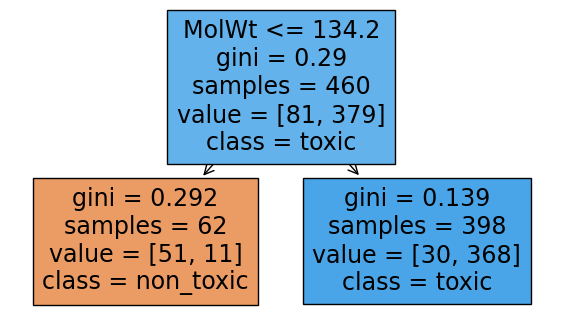

In [8]:
# Visualize stump
plt.figure(figsize=(7,4))
plot_tree(stump, feature_names=feat_names, class_names=["non_toxic","toxic"], filled=True, impurity=True)
plt.show()

---

## 3. Grow deeper and control overfitting

Trees can fit noise if we let them grow without limits. We control growth using a few simple knobs.

- `max_depth`: limit the number of levels
- `min_samples_split`: a node needs at least this many samples to split
- `min_samples_leaf`: each leaf must have at least this many samples

In [9]:
def fit_eval_tree(max_depth=None, min_leaf=1):
    clf = DecisionTreeClassifier(
        max_depth=max_depth, min_samples_leaf=min_leaf, random_state=0
    )
    clf.fit(X_train, y_train)
    acc = accuracy_score(y_test, clf.predict(X_test))
    return clf, acc

depths = [1, 2, 3, 4, 5, None]  # None means grow until pure or exhausted
scores = []
for d in depths:
    _, acc = fit_eval_tree(max_depth=d, min_leaf=3)
    scores.append(acc)

pd.DataFrame({"max_depth": [str(d) for d in depths], "Accuracy": np.round(scores,3)})

,max_depth,Accuracy
0,1,0.922
1,2,0.957
2,3,0.948
3,4,0.948
4,5,0.948
5,None,0.930


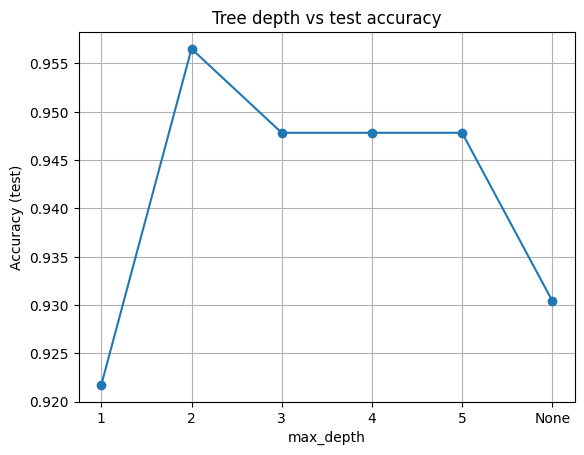

In [10]:
plt.plot([str(d) for d in depths], scores, marker="o")
plt.xlabel("max_depth")
plt.ylabel("Accuracy (test)")
plt.title("Tree depth vs test accuracy")
plt.grid(True)
plt.show()

```{admonition} Takeaway
Shallow trees underfit. Very deep trees often overfit. Start small, add depth only if validation improves.
```

### 3.1 Feature importance and permutation importance

In [11]:
tree_clf = DecisionTreeClassifier(max_depth=4, min_samples_leaf=3, random_state=0).fit(X_train, y_train)

imp = pd.Series(tree_clf.feature_importances_, index=feat_names).sort_values(ascending=False)
imp

MolWt       0.601322
LogP        0.291825
TPSA        0.085734
NumRings    0.021119
dtype: float64

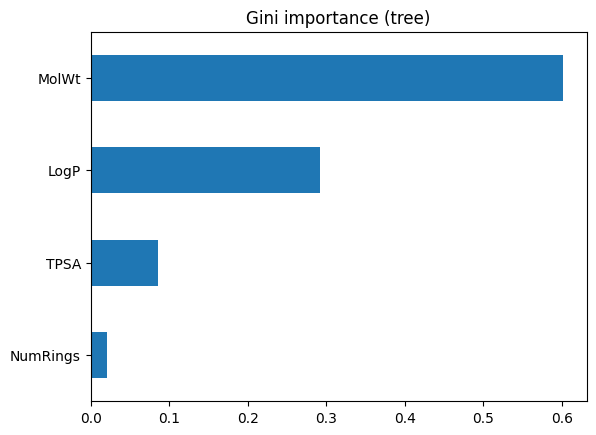

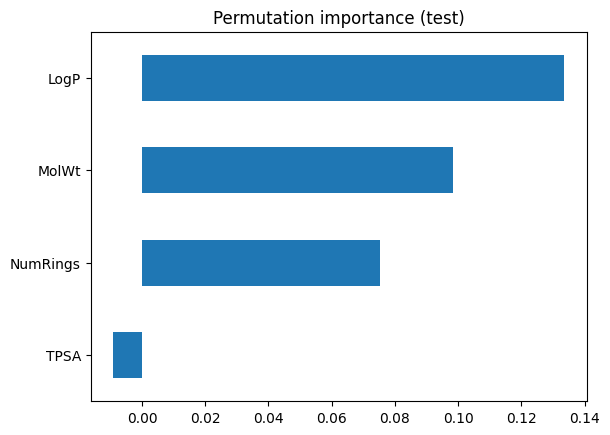

In [12]:
imp.plot(kind="barh")
plt.title("Gini importance (tree)")
plt.gca().invert_yaxis()
plt.show()

perm = permutation_importance(tree_clf, X_test, y_test, scoring="accuracy", n_repeats=20, random_state=0)
perm_ser = pd.Series(perm.importances_mean, index=feat_names).sort_values()
perm_ser.plot(kind="barh")
plt.title("Permutation importance (test)")
plt.show()

---

## 4. Regression trees on Melting Point

Now switch to a numeric target and watch the structures for a regressor.

In [13]:
df_reg = df[["MolWt", "LogP", "TPSA", "NumRings", "Melting Point"]].dropna()
Xr = df_reg[["MolWt", "LogP", "TPSA", "NumRings"]]
yr = df_reg["Melting Point"]

Xr_train, Xr_test, yr_train, yr_test = train_test_split(
    Xr, yr, test_size=0.2, random_state=42
)

Xr_train.head(2), yr_train.head(3)

(       MolWt    LogP  TPSA  NumRings
 68   226.703  3.6870  26.3       1.0
 231  282.295  2.5255  52.6       3.0,
 68     152.1
 231    169.4
 63     247.3
 Name: Melting Point, dtype: float64)

In [14]:
reg_stump = DecisionTreeRegressor(max_depth=1, random_state=0)
reg_stump.fit(Xr_train, yr_train)
print("Root feature:", Xr_train.columns[reg_stump.tree_.feature[0]])
print("Root threshold:", reg_stump.tree_.threshold[0])

Root feature: MolWt
Root threshold: 245.61299896240234


In [15]:
# Evaluate shallow vs deeper
depths = [1, 2, 3, 4, 6, 8, None]
r2s = []
for d in depths:
    reg = DecisionTreeRegressor(max_depth=d, min_samples_leaf=5, random_state=0).fit(Xr_train, yr_train)
    yhat = reg.predict(Xr_test)
    r2s.append(r2_score(yr_test, yhat))

pd.DataFrame({"max_depth": [str(d) for d in depths], "R2_test": np.round(r2s,3)})

,max_depth,R2_test
0,1,0.398
1,2,0.659
2,3,0.810
3,4,0.809
4,6,0.777
5,8,0.765
6,None,0.761


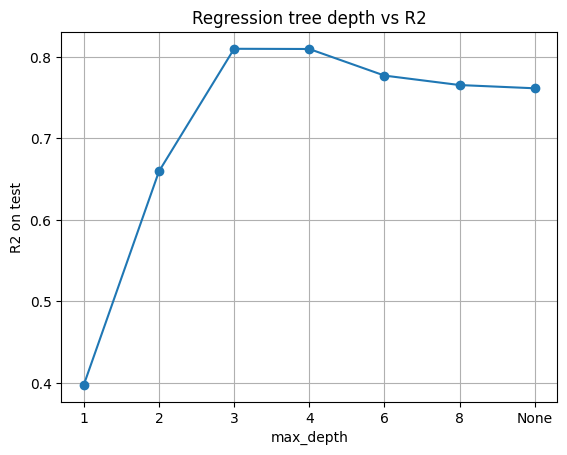

In [16]:
plt.plot([str(d) for d in depths], r2s, marker="o")
plt.xlabel("max_depth")
plt.ylabel("R2 on test")
plt.title("Regression tree depth vs R2")
plt.grid(True)
plt.show()

MSE=566.914
MAE=17.818
R2=0.809


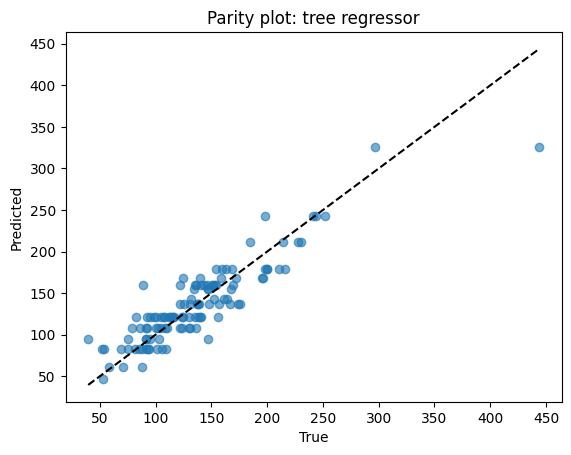

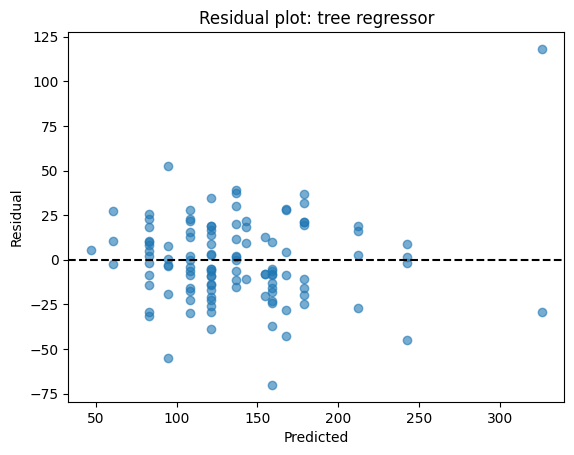

In [17]:
# Diagnostics for a chosen depth
reg = DecisionTreeRegressor(max_depth=4, min_samples_leaf=5, random_state=0).fit(Xr_train, yr_train)
yhat = reg.predict(Xr_test)

print(f"MSE={mean_squared_error(yr_test, yhat):.3f}")
print(f"MAE={mean_absolute_error(yr_test, yhat):.3f}")
print(f"R2={r2_score(yr_test, yhat):.3f}")

# Parity
plt.scatter(yr_test, yhat, alpha=0.6)
lims = [min(yr_test.min(), yhat.min()), max(yr_test.max(), yhat.max())]
plt.plot(lims, lims, "k--")
plt.xlabel("True")
plt.ylabel("Predicted")
plt.title("Parity plot: tree regressor")
plt.show()

# Residuals
res = yr_test - yhat
plt.scatter(yhat, res, alpha=0.6)
plt.axhline(0, color="k", linestyle="--")
plt.xlabel("Predicted")
plt.ylabel("Residual")
plt.title("Residual plot: tree regressor")
plt.show()

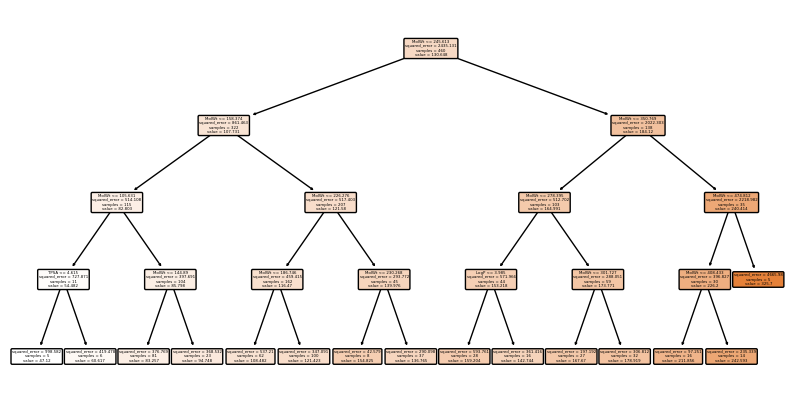

In [18]:
# Visualize a small regression tree
plt.figure(figsize=(10,5))
plot_tree(reg, feature_names=Xr_train.columns, filled=True, impurity=True, rounded=True, proportion=False)
plt.show()

---

## 5. Random Forest: bagging many trees

A random forest trains many trees on bootstrapped samples and averages them. Two main sources of diversity:

- **Bootstrap** sampling of rows for each tree.
- **Feature subsampling** at each split, controlled by `max_features`.

This reduces variance compared to a single deep tree.

### 5.1 Classification forest on toxicity

In [19]:
rf_clf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_leaf=3,
    max_features="sqrt",
    oob_score=True,
    random_state=0,
    n_jobs=-1
)
rf_clf.fit(X_train, y_train)

print("OOB score:", rf_clf.oob_score_)
acc = accuracy_score(y_test, rf_clf.predict(X_test))
print("Test accuracy:", acc)

OOB score: 0.9282608695652174
Test accuracy: 0.9478260869565217


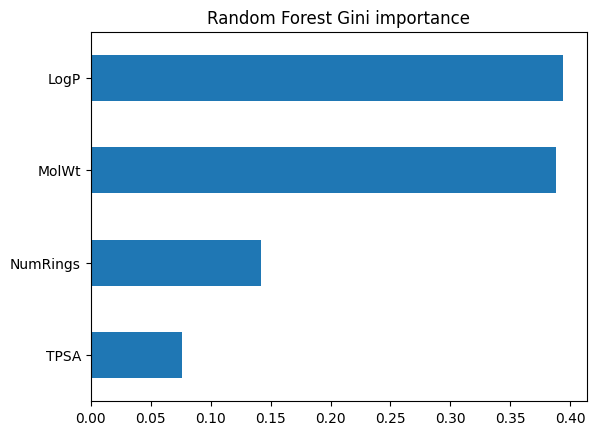

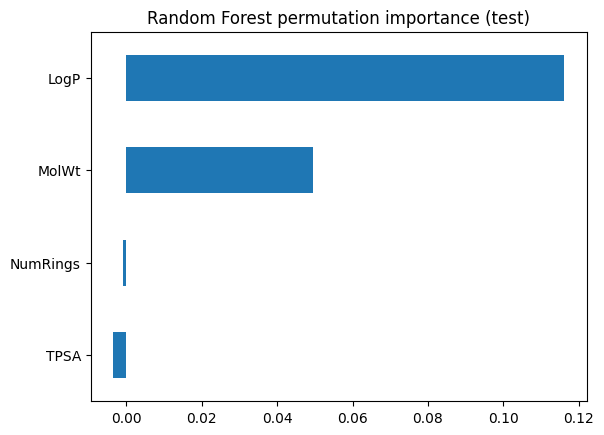

In [20]:
imp_rf = pd.Series(rf_clf.feature_importances_, index=feat_names).sort_values()
imp_rf.plot(kind="barh")
plt.title("Random Forest Gini importance")
plt.show()

perm_rf = permutation_importance(rf_clf, X_test, y_test, scoring="accuracy", n_repeats=20, random_state=0)
pd.Series(perm_rf.importances_mean, index=feat_names).sort_values().plot(kind="barh")
plt.title("Random Forest permutation importance (test)")
plt.show()

### 5.2 Regression forest on Melting Point

In [21]:
rf_reg = RandomForestRegressor(
    n_estimators=400,
    max_depth=None,
    min_samples_leaf=3,
    max_features="sqrt",
    oob_score=True,
    random_state=0,
    n_jobs=-1
)
rf_reg.fit(Xr_train, yr_train)

print("OOB R2:", rf_reg.oob_score_)
yhat_rf = rf_reg.predict(Xr_test)
print(f"Test R2: {r2_score(yr_test, yhat_rf):.3f}")
print(f"Test MAE: {mean_absolute_error(yr_test, yhat_rf):.3f}")

OOB R2: 0.7667408583830986
Test R2: 0.781
Test MAE: 17.577


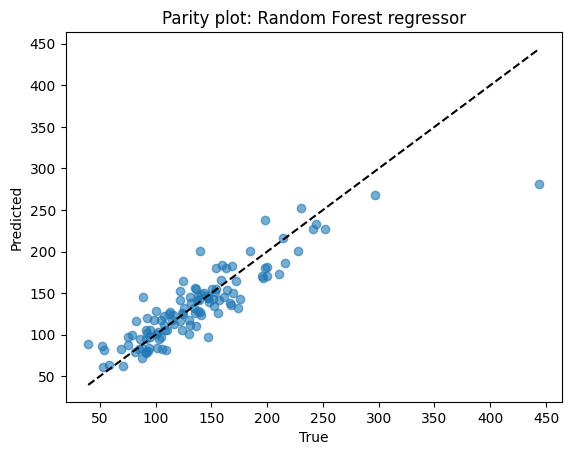

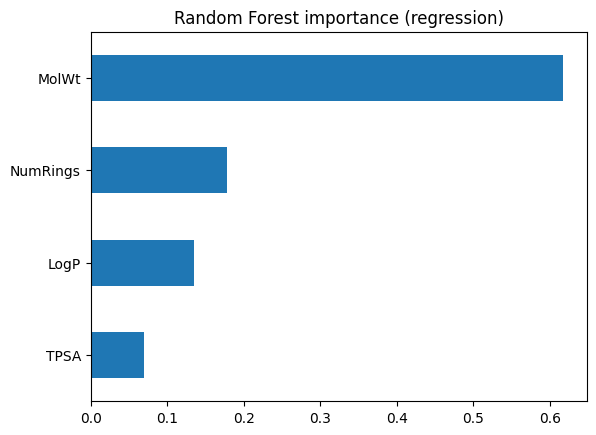

In [22]:
# Parity plot
plt.scatter(yr_test, yhat_rf, alpha=0.6)
lims = [min(yr_test.min(), yhat_rf.min()), max(yr_test.max(), yhat_rf.max())]
plt.plot(lims, lims, "k--")
plt.xlabel("True")
plt.ylabel("Predicted")
plt.title("Parity plot: Random Forest regressor")
plt.show()

# Feature importance
pd.Series(rf_reg.feature_importances_, index=Xr_train.columns).sort_values().plot(kind="barh")
plt.title("Random Forest importance (regression)")
plt.show()

---

## 6. Compare single tree vs forest

We look at stability across several random splits. This loop keeps code short but shows the lists of scores so students can inspect them.

In [23]:
splits = [1, 7, 21, 42, 77]
rows = []
for seed in splits:
    X_tr, X_te, y_tr, y_te = train_test_split(Xr, yr, test_size=0.2, random_state=seed)
    t = DecisionTreeRegressor(max_depth=None, min_samples_leaf=3, random_state=seed).fit(X_tr, y_tr)
    f = RandomForestRegressor(n_estimators=300, min_samples_leaf=3, random_state=seed, n_jobs=-1).fit(X_tr, y_tr)
    r2_t = r2_score(y_te, t.predict(X_te))
    r2_f = r2_score(y_te, f.predict(X_te))
    rows.append({"seed": seed, "Tree_R2": r2_t, "Forest_R2": r2_f})

pd.DataFrame(rows).round(3)

,seed,Tree_R2,Forest_R2
0,1,0.710,0.801
1,7,0.670,0.794
2,21,0.771,0.792
3,42,0.747,0.824
4,77,0.768,0.814


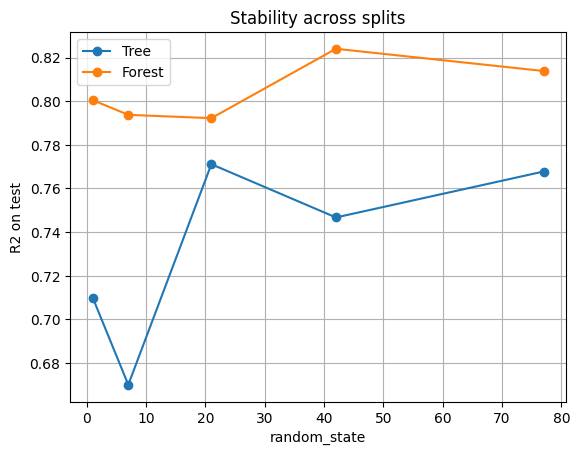

In [24]:
df_cmp = pd.DataFrame(rows)
plt.plot(df_cmp["seed"], df_cmp["Tree_R2"], "o-", label="Tree")
plt.plot(df_cmp["seed"], df_cmp["Forest_R2"], "o-", label="Forest")
plt.xlabel("random_state")
plt.ylabel("R2 on test")
plt.title("Stability across splits")
plt.legend()
plt.grid(True)
plt.show()

```{admonition} Observation
Forests tend to give higher and more stable test performance than a single deep tree.
```

---

## 7. End-to-end recipe

Short workflow for toxicity with a forest.

In [25]:
# 1) Data
X = df_clf[["MolWt", "LogP", "TPSA", "NumRings"]]
y = df_clf["Toxicity"].str.lower().map(label_map).astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=15, stratify=y
)

# 2) Model
rf = RandomForestClassifier(
    n_estimators=400, max_depth=None, max_features="sqrt",
    min_samples_leaf=3, oob_score=True, random_state=15, n_jobs=-1
).fit(X_train, y_train)

# 3) Evaluate
y_hat = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:,1]
print(f"OOB score: {rf.oob_score_:.3f}")
print(f"Accuracy: {accuracy_score(y_test, y_hat):.3f}")
print(f"AUC: {roc_auc_score(y_test, y_proba):.3f}")

OOB score: 0.939
Accuracy: 0.922
AUC: 0.955


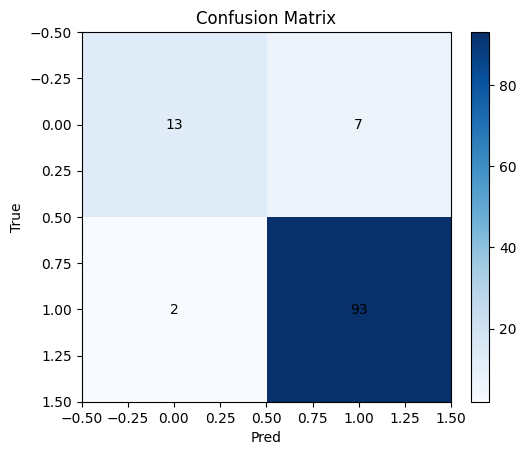

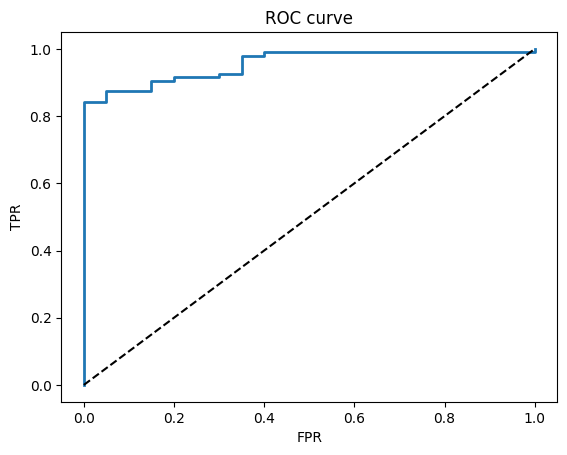

In [26]:
# Confusion matrix and ROC
cm = confusion_matrix(y_test, y_hat)
plt.imshow(cm, cmap="Blues"); plt.title("Confusion Matrix"); plt.xlabel("Pred"); plt.ylabel("True")
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i,j], ha="center", va="center")
plt.colorbar(fraction=0.046, pad=0.04)
plt.show()

fpr, tpr, thr = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, lw=2); plt.plot([0,1],[0,1],"k--")
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC curve")
plt.show()

---

## 8. Quick reference

```{admonition} Common options
- DecisionTreeClassifier/Regressor: `max_depth`, `min_samples_leaf`, `min_samples_split`, `criterion`, `random_state`
- RandomForestClassifier/Regressor: add `n_estimators`, `max_features`, `oob_score`, `n_jobs`
- Use `feature_importances_` for built-in importance and `permutation_importance` for model-agnostic view
```
```{admonition} When to use
- Tree: simple rules, quick to interpret on small depth
- Forest: stronger accuracy, more stable, less sensitive to a single split
```

---

## 9. In-class activities

### 9.1 Tree vs Forest on log-solubility

- Create `y_log = log10(Solubility_mol_per_L + 1e-6)`
- Use features `[MolWt, LogP, TPSA, NumRings]`
- Train a `DecisionTreeRegressor(max_depth=4, min_samples_leaf=5)` and a `RandomForestRegressor(n_estimators=300, min_samples_leaf=5)`
- Report test **R2** for both and draw both parity plots

```python
# TO DO
```

### 9.2 Pruning with `min_samples_leaf`

- Fix `max_depth=None` for `DecisionTreeClassifier` on toxicity
- Sweep `min_samples_leaf` in `[1, 2, 3, 5, 8, 12, 20]`
- Plot test **accuracy** vs `min_samples_leaf`

```python
# TO DO
```

### 9.3 OOB sanity check

- Train `RandomForestClassifier` with `oob_score=True` on toxicity
- Compare OOB score to test accuracy over seeds `[0, 7, 21, 42]`

```python
# TO DO
```

### 9.4 Feature importance agreement

- On melting point, compute forest `feature_importances_` and `permutation_importance`
- Plot both and comment where they agree or disagree

```python
# TO DO
```

### 9.5 Small tree visualization

- Fit a `DecisionTreeClassifier(max_depth=2)` on toxicity
- Use `plot_tree` to draw it and write down the two split rules in plain language

```python
# TO DO
```

---